In [1]:
import datetime

import numpy as np 
import pandas as pd

from scipy import stats
from skmultiflow.drift_detection import KSWIN

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

matplotlib.rcParams['figure.figsize'] = (20, 8)

In [2]:
odi_df = pd.read_csv("odi_data_backup.csv", parse_dates=[1], infer_datetime_format=True)
odi_df.drop(["Unnamed: 0"], axis=1, inplace=True)
odi_df.head()

,Date,Team1,Team2,Team1_id,Team2_id,Winning_team_id,cancelled_match,floodlit,innings1_ball_limit,innings2_ball_limit,innings1_over_limit,innings2_over_limit,innings1_runs,innings2_runs,innings1_wickets,innings2_wickets,innings1_run_rate,innings2_run_rate
0,"Jan 5, 1971",Australia,England,2,2,1,N,1,320,320,40.0,40.0,190,191,10,5,3.60,4.12
1,"Feb 11, 1973",New Zealand,Pakistan,5,5,7,N,1,320,320,40.0,40.0,187,165,10,10,3.65,3.70
2,"Mar 30, 1974",New Zealand,Australia,2,5,2,N,1,280,280,35.0,35.0,194,195,9,3,4.15,6.00
3,"Mar 31, 1974",New Zealand,Australia,2,5,2,N,1,280,280,35.0,35.0,265,234,5,6,5.67,5.01
4,"Jan 1, 1975",Australia,England,1,2,1,N,1,320,320,40.0,40.0,190,191,10,7,4.11,3.85


In [3]:
odi_sorted_df = pd.read_excel("odi_sorted.xlsx", parse_dates=[9])
odi_sorted_df.columns = ['Team', 'Runs', 'Wkts', 'Balls', 'Ave', 'RPO', 'Result', 'Opposition','Ground', 'Date']
odi_sorted_df.sort_values("Date", ascending=True, inplace=True,ignore_index=True)
odi_sorted_df.head()

,Team,Runs,Wkts,Balls,Ave,RPO,Result,Opposition,Ground,Date
0,Australia,191,5,278,38.2,4.12,won,v England,Melbourne,1971-01-05
1,England,190,10,316,19,3.6,lost,v Australia,Melbourne,1971-01-05
2,England,226,4,295,56.5,4.59,won,v Australia,Manchester,1972-08-24
3,Australia,222,8,330,27.75,4.03,lost,v England,Manchester,1972-08-24
4,Australia,240,5,309,48,4.66,won,v England,Lord's,1972-08-26


# Analysis first innings scores where over limit was 50 overs

In [4]:
df = odi_df[odi_df["innings1_over_limit"] == 50][["Date","innings1_runs","innings1_run_rate"]]
df = df[df.Date.str.len() < 13]
df["Date"] = df["Date"].astype('datetime64')
df.sort_values(by="Date", axis=0,ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)
df

,Date,innings1_runs,innings1_run_rate
0,1974-08-31,244,4.88
1,1978-02-22,313,6.26
2,1979-11-27,193,3.89
3,1979-11-28,211,4.22
4,1979-12-08,207,4.14
...,...,...,...
1700,2005-04-02,281,5.62
1701,2005-04-05,356,7.12
1702,2005-04-09,319,6.38
1703,2005-04-15,249,4.98


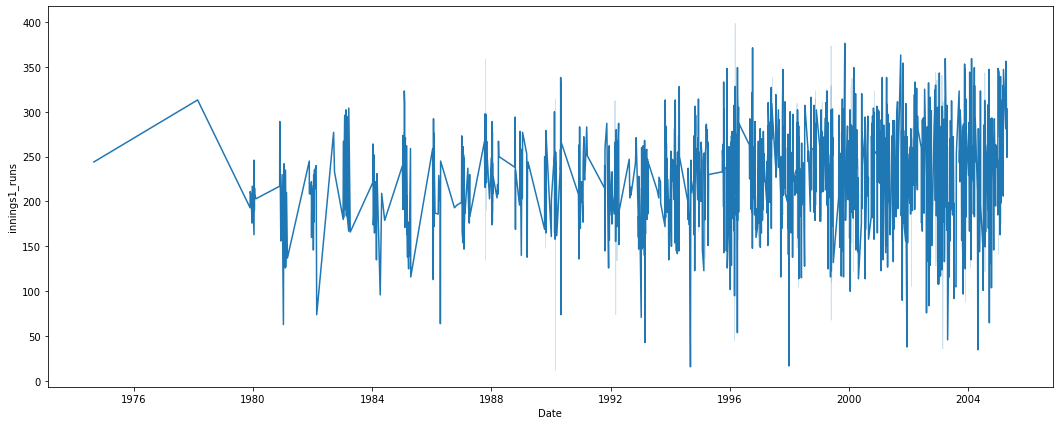

In [5]:
fig, ax = plt.subplots(figsize=(18, 7))
fig = sns.lineplot(x="Date", y="innings1_runs", data=df)
#plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

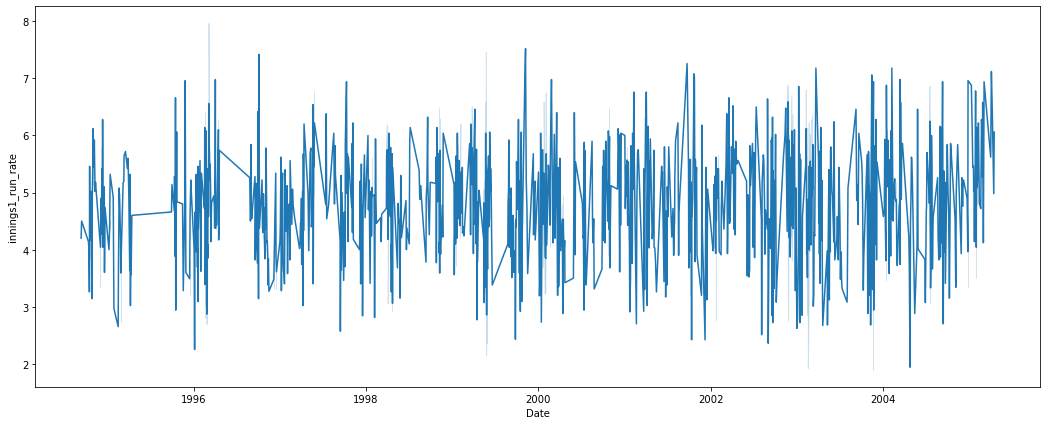

In [6]:
fig, ax = plt.subplots(figsize=(18, 7))
fig = sns.lineplot(x="Date", y="innings1_run_rate", data=df.iloc[500:])
#plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

# Prepare a baseline of data older than 2000

In [7]:
baseline = df.loc[(df["Date"] > "1990-01-01") & (df["Date"] < "2000-01-01")]

In [8]:
for i in np.arange(2001,2020):
    frm = f"{i}-01-01"
    to = f"{i+1}-01-01"
    target = df.loc[(df["Date"] > frm) & (df["Date"] < to)]
    if len(target) > 0 :
        print(frm,to)
        print(stats.ks_2samp(baseline.iloc[:,1], target.iloc[:,1],mode='asymp'))

2001-01-01 2002-01-01
Ks_2sampResult(statistic=0.14765781791643862, pvalue=0.027888849075156163)
2002-01-01 2003-01-01
Ks_2sampResult(statistic=0.20559060486465203, pvalue=0.00013401748717961414)
2003-01-01 2004-01-01
Ks_2sampResult(statistic=0.10412760522811881, pvalue=0.14982412050994423)
2004-01-01 2005-01-01
Ks_2sampResult(statistic=0.1479108036935317, pvalue=0.026579009591231044)
2005-01-01 2006-01-01
Ks_2sampResult(statistic=0.43167305236270753, pvalue=5.375229793940609e-06)


# Analyse sorted runs table

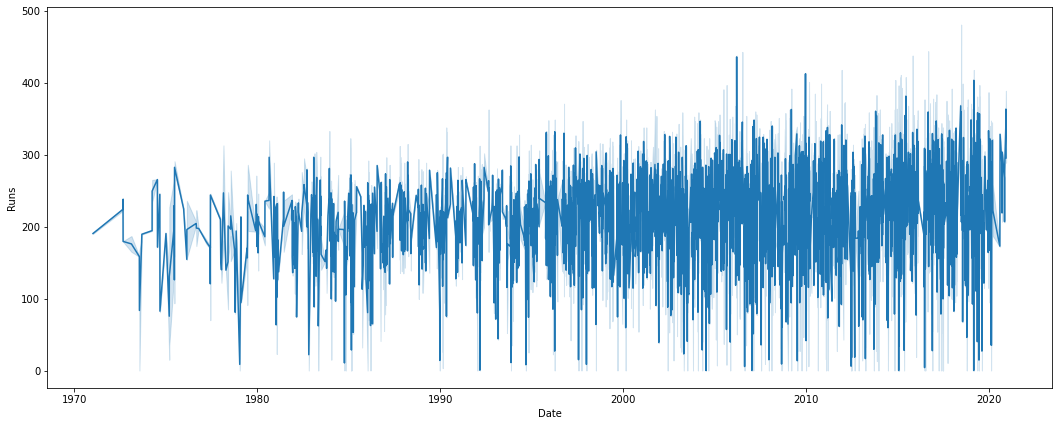

In [9]:
fig, ax = plt.subplots(figsize=(18, 7))
fig = sns.lineplot(x="Date", y="Runs",data=odi_sorted_df)
plt.show()

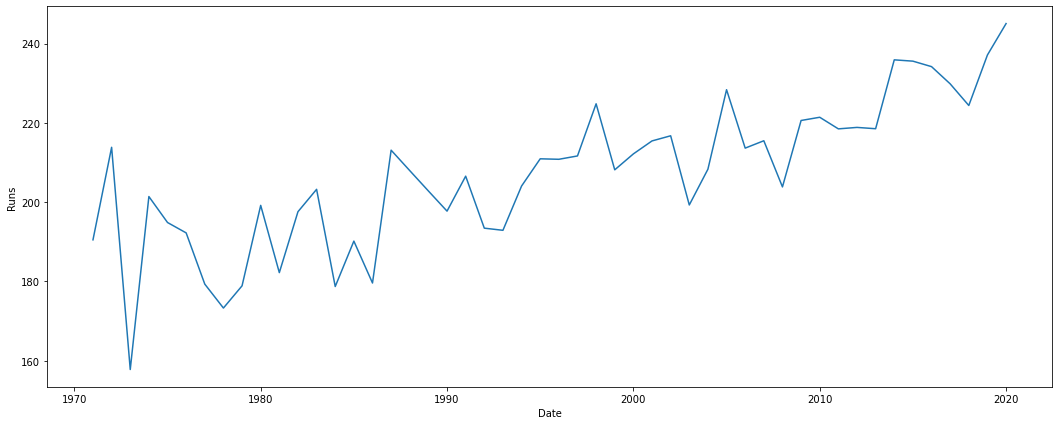

In [10]:
# yearly avg
df = odi_sorted_df.copy()
yearly_avg = df.groupby(df.Date.dt.year)['Runs'].mean()

fig, ax = plt.subplots(figsize=(18, 7))
fig = sns.lineplot(x=yearly_avg.index, y=yearly_avg)
plt.show()

In [11]:
import statsmodels.stats.api as sms



In [12]:
from functools import reduce
def confidence_interval(series):
       return sms.DescrStatsW(series).tconfint_mean()
    
df.groupby(df.Date.dt.year)['Runs'].agg(confidence_interval)

Date
1971    (184.14689763178396, 196.85310236821604)
1972    (185.09782570246594, 242.56884096420075)
1973     (117.17511707667992, 198.4248829233201)
1974    (159.75580979486338, 243.07752353846993)
1975    (166.88881606320314, 222.84802604206004)
1976    (174.44083484456056, 210.05916515543944)
1977    (149.65607989160355, 209.01058677506313)
1978     (144.63642760984143, 201.9635723901586)
1979    (160.82001640852525, 196.98767589916707)
1980    (186.37755762304738, 212.00339475790503)
1981     (168.4507458130631, 196.01353990122263)
1982    (184.03674218635993, 211.14507599545826)
1983    (193.28452974132725, 213.18516722836975)
1984    (168.44591820195717, 189.00506219019968)
1985    (180.31726096542664, 200.03658518841954)
1986     (169.27987499561823, 189.9459314559947)
1987       (205.902675668594, 220.3135405476222)
1988     (200.5437290736272, 215.35791027063513)
1989    (192.98537076434886, 212.65099287201477)
1990     (187.43701443389978, 208.0383954021658)
1991    (197.11

## Prepare a baseline of data older than 2000

In [13]:
baseline = odi_sorted_df.loc[(odi_sorted_df["Date"] > "2015-01-01") & (odi_sorted_df["Date"] < "2019-01-01") ] # & (df["Date"] < "2000-01-01")
baseline.head()

,Team,Runs,Wkts,Balls,Ave,RPO,Result,Opposition,Ground,Date
7142,Scotland,237,8,270,29.62,5.26,lost,v Afghanistan,ICCA Dubai,2015-01-08
7143,Afghanistan,240,2,228,120,6.31,won,v Scotland,ICCA Dubai,2015-01-08
7144,Ireland,181,7,260,25.85,4.17,won,v Afghanistan,Dubai (DSC),2015-01-10
7145,Afghanistan,180,10,266,18,4.06,lost,v Ireland,Dubai (DSC),2015-01-10
7146,New Zealand,219,7,258,31.28,5.09,won,v Sri Lanka,Christchurch,2015-01-11


## KS sample comparison

In [14]:
df = odi_sorted_df.copy()
for i in np.arange(2016,2020):
    frm = f"{i}-01-01"
    to = f"{i+1}-01-01"
    target = df.loc[(df["Date"] > frm) & (df["Date"] < to)]
    if len(target) > 0 :
        print(frm,to)
        print(stats.ks_2samp(baseline.iloc[:,1], target.iloc[:,1],mode='asymp'))

2016-01-01 2017-01-01
Ks_2sampResult(statistic=0.0774578453861322, pvalue=0.2741796773560433)
2017-01-01 2018-01-01
Ks_2sampResult(statistic=0.036080484264492396, pvalue=0.9520838790078634)
2018-01-01 2019-01-01
Ks_2sampResult(statistic=0.06643737549800799, pvalue=0.32885516250455304)
2019-01-01 2020-01-01
Ks_2sampResult(statistic=0.07162018592297476, pvalue=0.18688000671176505)


In [15]:
baseline_temp = baseline.copy()
baseline_temp["Source"] = "Baseline"

target_temp = target.copy()
target_temp["Source"] = "Target"

df = baseline_temp.append(target_temp)
df.head()

,Team,Runs,Wkts,Balls,Ave,RPO,Result,Opposition,Ground,Date,Source
7142,Scotland,237,8,270,29.62,5.26,lost,v Afghanistan,ICCA Dubai,2015-01-08,Baseline
7143,Afghanistan,240,2,228,120,6.31,won,v Scotland,ICCA Dubai,2015-01-08,Baseline
7144,Ireland,181,7,260,25.85,4.17,won,v Afghanistan,Dubai (DSC),2015-01-10,Baseline
7145,Afghanistan,180,10,266,18,4.06,lost,v Ireland,Dubai (DSC),2015-01-10,Baseline
7146,New Zealand,219,7,258,31.28,5.09,won,v Sri Lanka,Christchurch,2015-01-11,Baseline


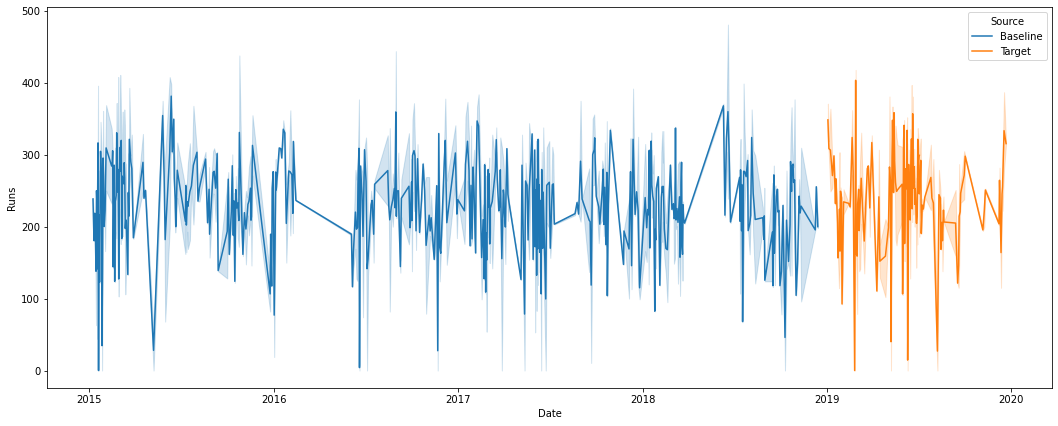

In [16]:
fig, ax = plt.subplots(figsize=(18, 7))
fig = sns.lineplot(x=df.Date, y=df.Runs, hue=df.Source)
plt.show()

## History window comparison

In [17]:
df = odi_sorted_df[odi_sorted_df["Balls"] >= 240].copy()
windows = []
start_year=1971
end_year=2020
threshold = 0.5

for window_size in np.arange(1,2):

    start = start_year + window_size
    drift = []

    for i in np.arange(start,end_year):
        target_frm = f"{i}-01-01"
        target_to = f"{i+1}-01-01"

        baseline_frm = f"{i-window_size}-01-01"
        baseline_to = f"{i}-01-01"

        baseline = df.loc[(df["Date"] > baseline_frm) & (df["Date"] < baseline_to)]
        target = df.loc[(df["Date"] > target_frm) & (df["Date"] < target_to)]

        row=[]
        if len(target) > 0 and len(baseline) > 0:
            stat=stats.ks_2samp(baseline.iloc[:,1], target.iloc[:,1],mode='asymp')
            row = [baseline_frm,baseline_to,target_frm,target_to,stat.statistic, stat.pvalue]
            drift.append(row)

    drift_df = pd.DataFrame(drift)
    window = [window_size, drift_df[5].mean(), drift_df[5].sum(), (drift_df[5] > threshold).sum()]
    windows.append(window)

windows_df = pd.DataFrame(windows, columns=["Window_size", "Mean", "Sum", "Count_Above_threshold"])
windows_df

,Window_size,Mean,Sum,Count_Above_threshold
0,1,0.315481,15.143074,14


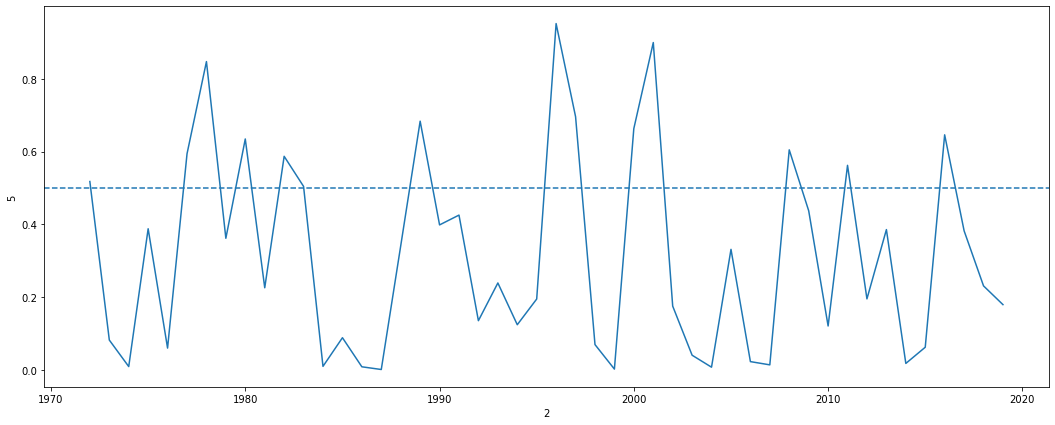

In [18]:
drift_df[2] = pd.to_datetime(drift_df[2])
fig, ax = plt.subplots(figsize=(18, 7))
fig = sns.lineplot(x=drift_df[2], y=drift_df[5])
ax.axhline(threshold , ls='--')
plt.show()

In [19]:
drift_df

,0,1,2,3,4,5
0,1971-01-01,1972-01-01,1972-01-01,1973-01-01,0.666667,0.517551
1,1972-01-01,1973-01-01,1973-01-01,1974-01-01,0.666667,0.081519
2,1973-01-01,1974-01-01,1974-01-01,1975-01-01,0.777778,0.008640
3,1974-01-01,1975-01-01,1975-01-01,1976-01-01,0.344828,0.387625
4,1975-01-01,1976-01-01,1976-01-01,1977-01-01,0.486207,0.059455
5,1976-01-01,1977-01-01,1977-01-01,1978-01-01,0.336364,0.593909
6,1977-01-01,1978-01-01,1978-01-01,1979-01-01,0.246753,0.847415
7,1978-01-01,1979-01-01,1979-01-01,1980-01-01,0.282540,0.361427
8,1979-01-01,1980-01-01,1980-01-01,1981-01-01,0.160976,0.634569
9,1980-01-01,1981-01-01,1981-01-01,1982-01-01,0.226718,0.225345


In [20]:
stats.ks_2samp(baseline.iloc[:,1], target.iloc[:,1],mode='asymp')

Ks_2sampResult(statistic=0.1073746844572665, pvalue=0.17898328977729344)

<AxesSubplot:xlabel='2', ylabel='5'>

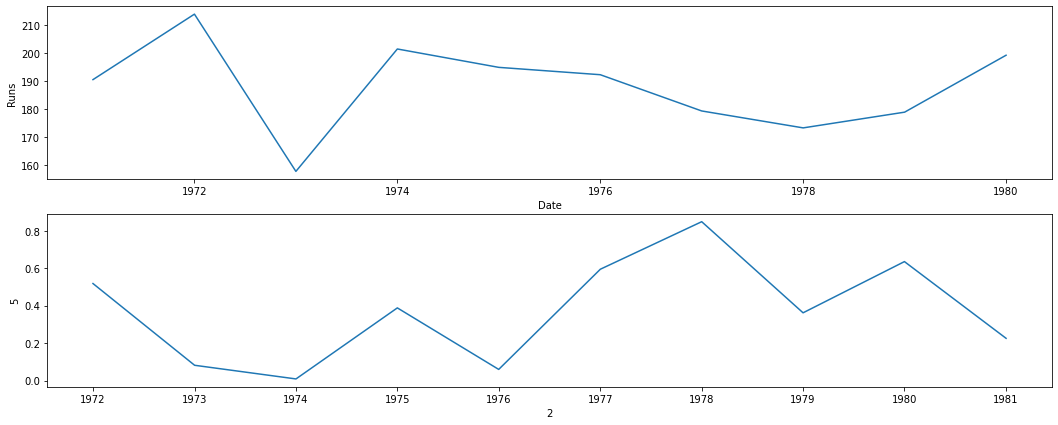

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(18, 7))
sns.lineplot(x=yearly_avg.index[:10], y=yearly_avg[:10], ax=ax1)
sns.lineplot(x=drift_df.iloc[:10,2], y=drift_df.iloc[:10,5], ax=ax2)


In [22]:
drift_df.append({0:"1970-01-01",1:"1971-01-01",2:"1971-01-01",3:"1972-01-01",4:0,5:0}, ignore_index=True)

,0,1,2,3,4,5
0,1971-01-01,1972-01-01,1972-01-01 00:00:00,1973-01-01,0.666667,0.517551
1,1972-01-01,1973-01-01,1973-01-01 00:00:00,1974-01-01,0.666667,0.081519
2,1973-01-01,1974-01-01,1974-01-01 00:00:00,1975-01-01,0.777778,0.008640
3,1974-01-01,1975-01-01,1975-01-01 00:00:00,1976-01-01,0.344828,0.387625
4,1975-01-01,1976-01-01,1976-01-01 00:00:00,1977-01-01,0.486207,0.059455
5,1976-01-01,1977-01-01,1977-01-01 00:00:00,1978-01-01,0.336364,0.593909
6,1977-01-01,1978-01-01,1978-01-01 00:00:00,1979-01-01,0.246753,0.847415
7,1978-01-01,1979-01-01,1979-01-01 00:00:00,1980-01-01,0.282540,0.361427
8,1979-01-01,1980-01-01,1980-01-01 00:00:00,1981-01-01,0.160976,0.634569
9,1980-01-01,1981-01-01,1981-01-01 00:00:00,1982-01-01,0.226718,0.225345


# % of matches above thresholds

In [23]:
df = odi_sorted_df[odi_sorted_df["Balls"] >= 240].copy() #odi_sorted_df["Team"] == "India"  & odi_sorted_df["Balls"] == 240
all_counts = df.groupby(df.Date.dt.year)["Runs"].count()

threshold = 250
above_threshold250_counts = df[df["Runs"] >= threshold].groupby(df.Date.dt.year)["Runs"].count()

threshold = 275
above_threshold275_counts = df[df["Runs"] >= threshold].groupby(df.Date.dt.year)["Runs"].count()

threshold = 300
above_threshold300_counts = df[df["Runs"] >= threshold].groupby(df.Date.dt.year)["Runs"].count()

above_threshold_percentage = []

for i in np.arange(1971,2021):    
    row = []
    row.append(i)
    
    try:
        total = all_counts[i]
    except KeyError:
        continue
    try:
        above250 = above_threshold250_counts[i]
    except KeyError:
        above250 = 0

    try:
        above275 = above_threshold275_counts[i]
    except KeyError:
        above275 = 0

    try:
        above300 = above_threshold300_counts[i]
    except KeyError:
        above300 = 0
    
    finally:
        row.append(round(above250/total*100,2))
        row.append(round(above275/total*100,2))
        row.append(round(above300/total*100,2))
        above_threshold_percentage.append(row)
        
above_threshold_percentage_df = pd.DataFrame(above_threshold_percentage, columns=["Year","Percentage250", "Percentage275", "Percentage300"]).set_index("Year")  

<AxesSubplot:xlabel='Year'>

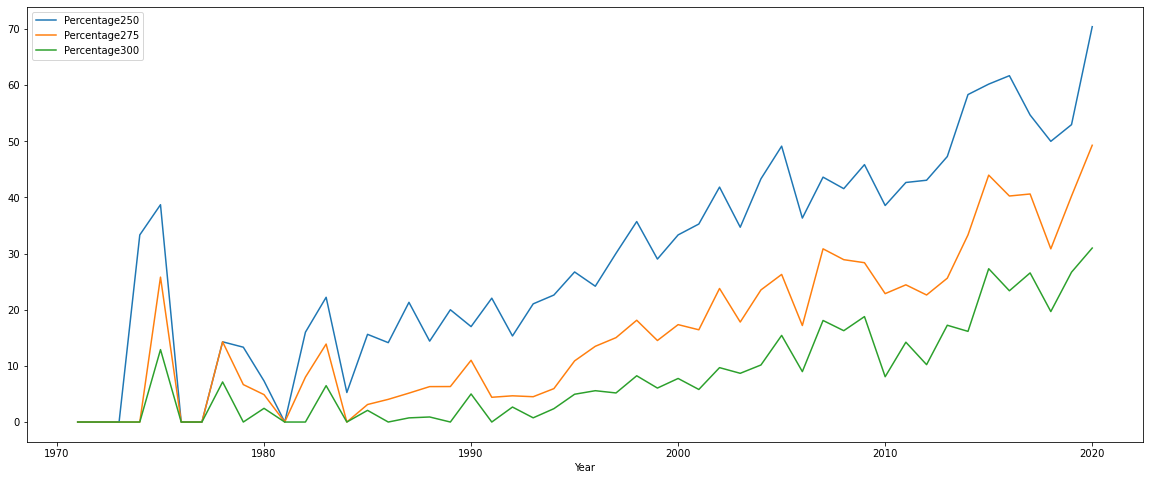

In [24]:
above_threshold_percentage_df.plot(figsize=(20,8))

In [25]:
all_counts

Date
1971      2
1972      6
1973      9
1974      9
1975     31
1976     10
1977     11
1978     14
1979     45
1980     41
1981     44
1982     50
1983    108
1984     76
1985     96
1986     99
1987    136
1988    111
1989     95
1990    100
1991     68
1992    150
1993    133
1994    168
1995    101
1996    215
1997    193
1998    182
1999    248
2000    219
2001    207
2002    227
2003    219
2004    187
2005    175
2006    256
2007    282
2008    166
2009    229
2010    223
2011    225
2012    137
2013    203
2014    192
2015    216
2016    154
2017    192
2018    188
2019    236
2020     71
Name: Runs, dtype: int64

# Windowing analysis

In [26]:
baseline = odi_sorted_df[(odi_sorted_df["Date"] >= "2016-01-01") & (odi_sorted_df["Date"] < "2017-01-01") & (odi_sorted_df["Balls"] >= 240)]
target = odi_sorted_df[(odi_sorted_df["Date"] >= "2017-01-01" ) & (odi_sorted_df["Date"] <= "2018-01-01") & (odi_sorted_df["Balls"] >= 240)]

Drift detected with pvalue:	 0.14557088074751318
Drift detected with pvalue:	 0.2053558992851101
Drift detected with pvalue:	 0.2713953253332405
Drift detected with pvalue:	 0.21254617351732177
Drift detected with pvalue:	 0.09565516784008772
Drift detected with pvalue:	 0.14251801461178823
Drift detected with pvalue:	 0.2003880927095886
Drift detected with pvalue:	 0.268540521972045
Drift detected with pvalue:	 0.1851000004955609
Drift detected with pvalue:	 0.09345894802927453
Drift detected with pvalue:	 0.127938482683639
Drift detected with pvalue:	 0.169209861520845
Drift detected with pvalue:	 0.21717496645814102
Drift detected with pvalue:	 0.2714601821504862
Drift detected with pvalue:	 0.2922668995734891
Drift detected with pvalue:	 0.17466431048818662
Drift detected with pvalue:	 0.1002045580102176
Drift detected with pvalue:	 0.12654749140939403
Drift detected with pvalue:	 0.15686468389038438
Drift detected with pvalue:	 0.19117643472277052
Drift detected with pvalue:	 0.22

C:\Users\I301903\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


Drift detected with pvalue:	 0.2713953253332409
Drift detected with pvalue:	 0.267243584934754
Drift detected with pvalue:	 0.20414353923896547
Drift detected with pvalue:	 0.27569234334407533
Drift detected with pvalue:	 0.2124643498849491
Drift detected with pvalue:	 0.28346502224339015


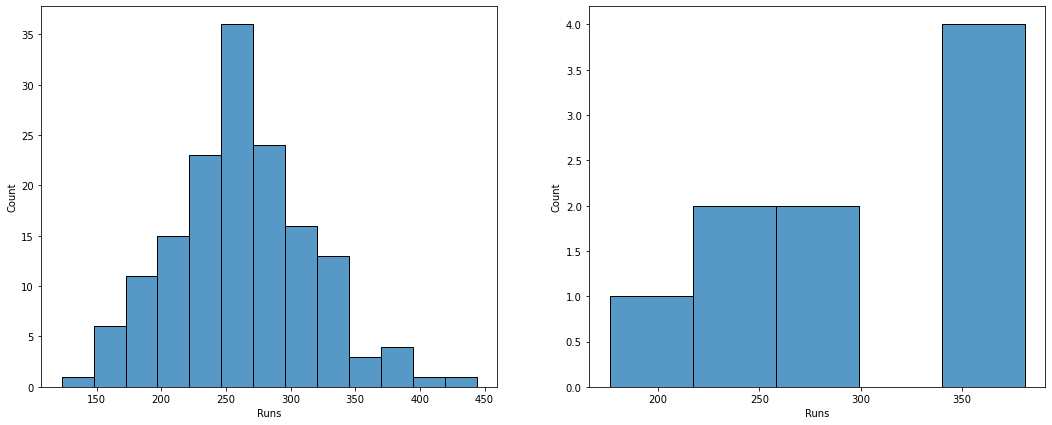

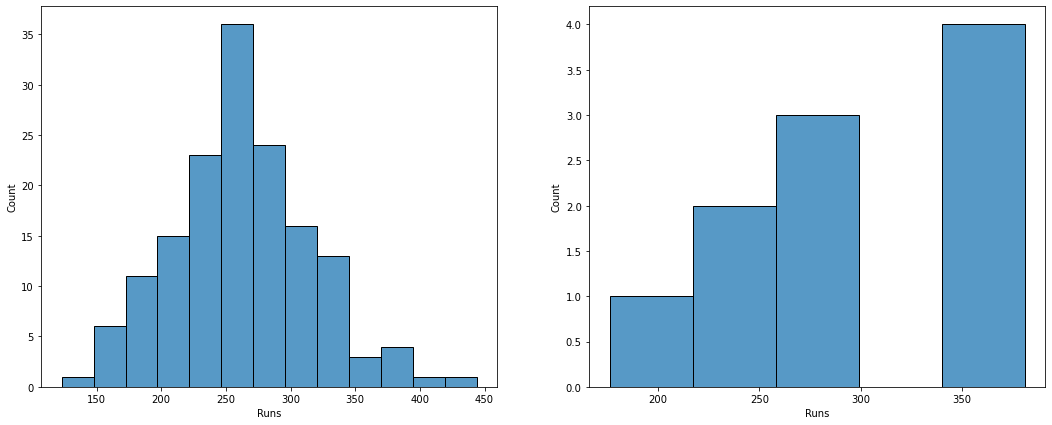

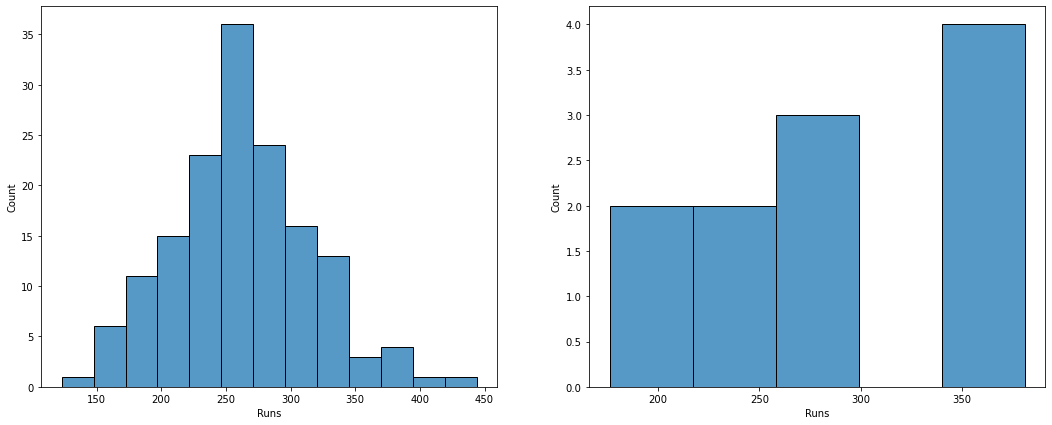

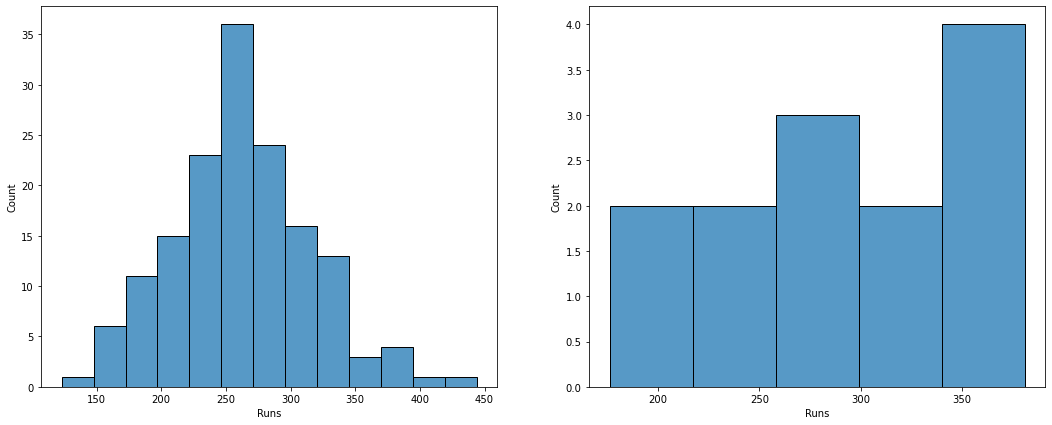

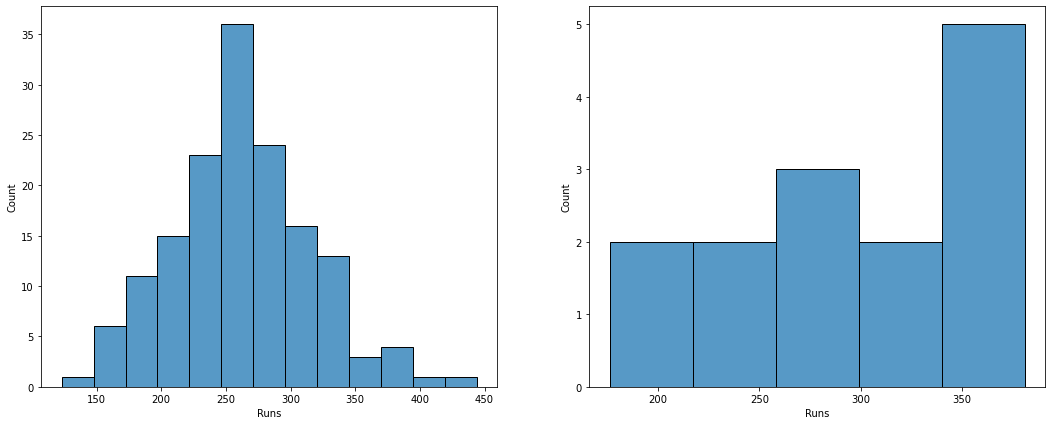

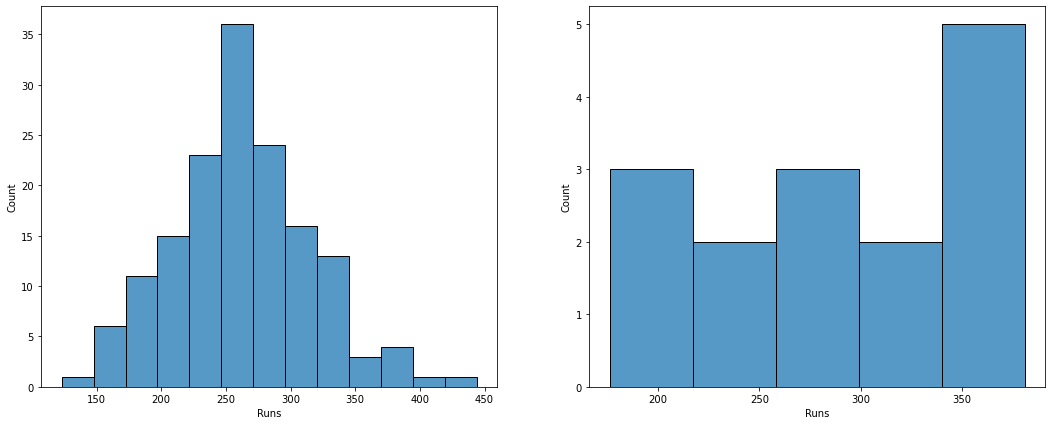

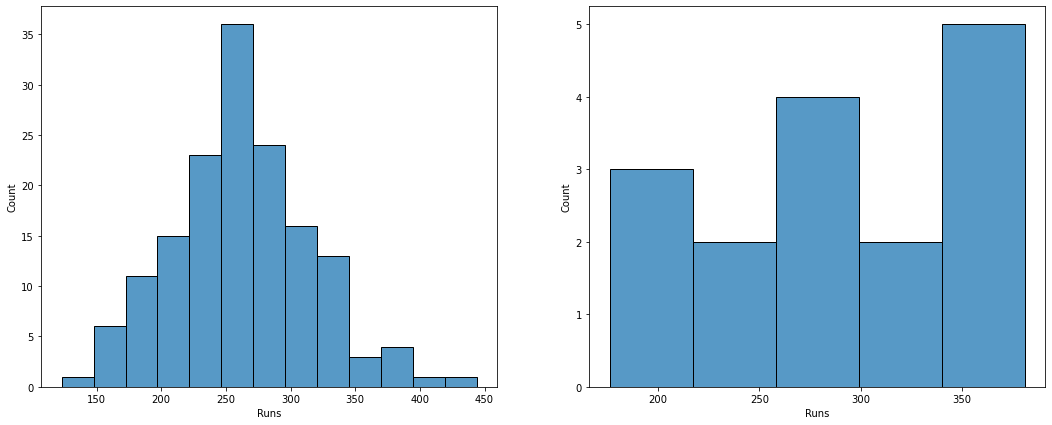

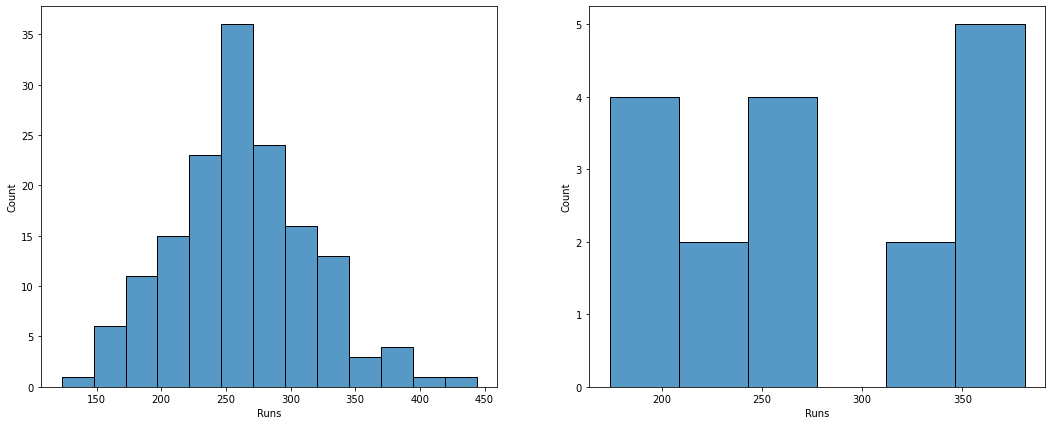

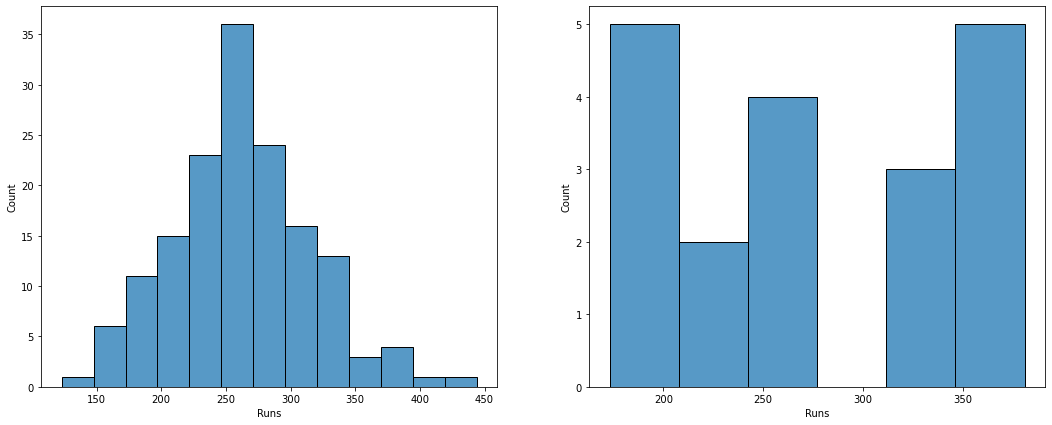

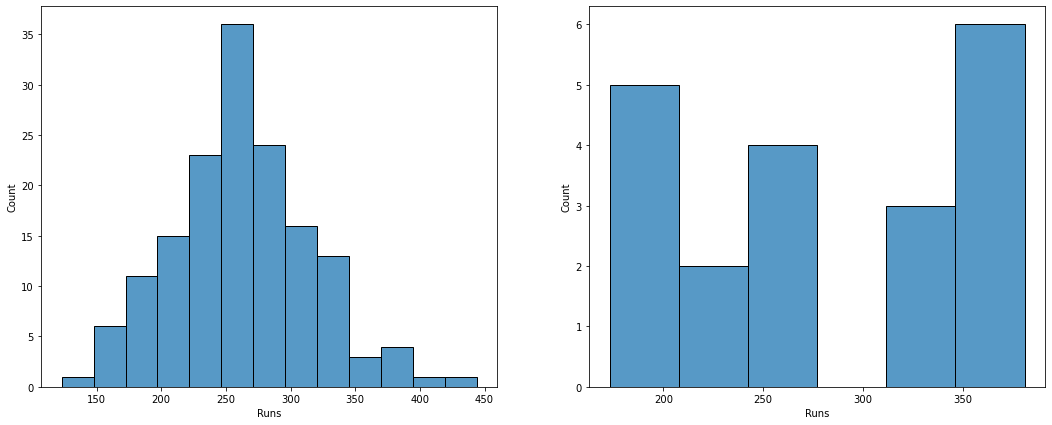

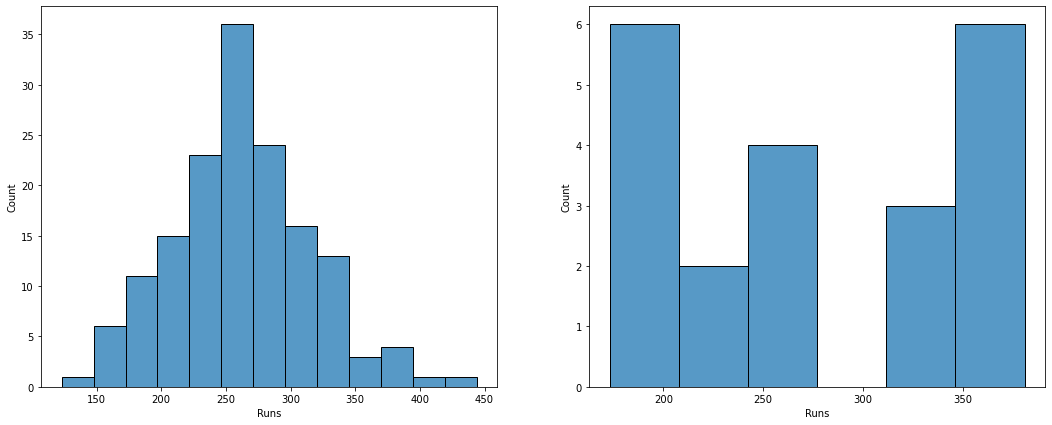

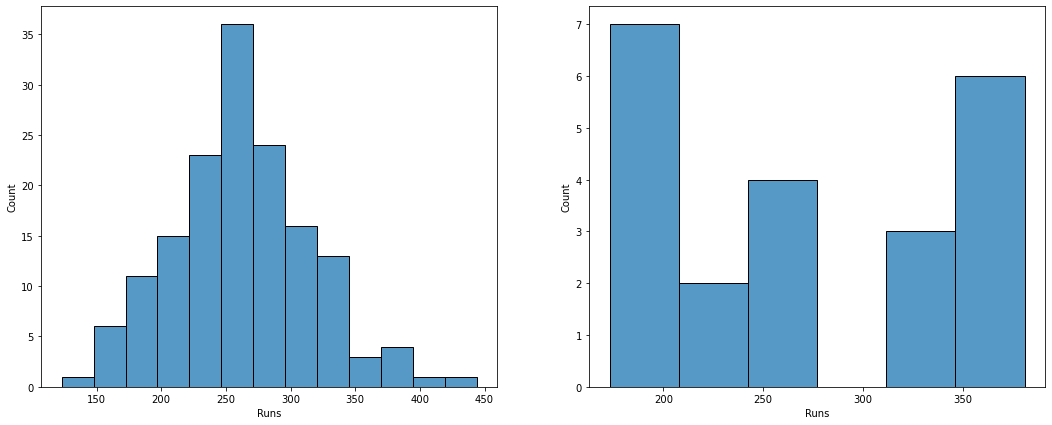

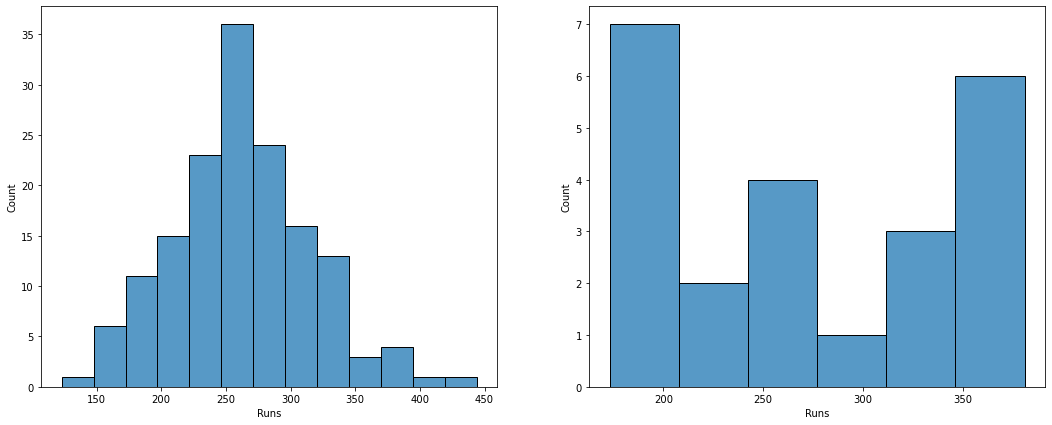

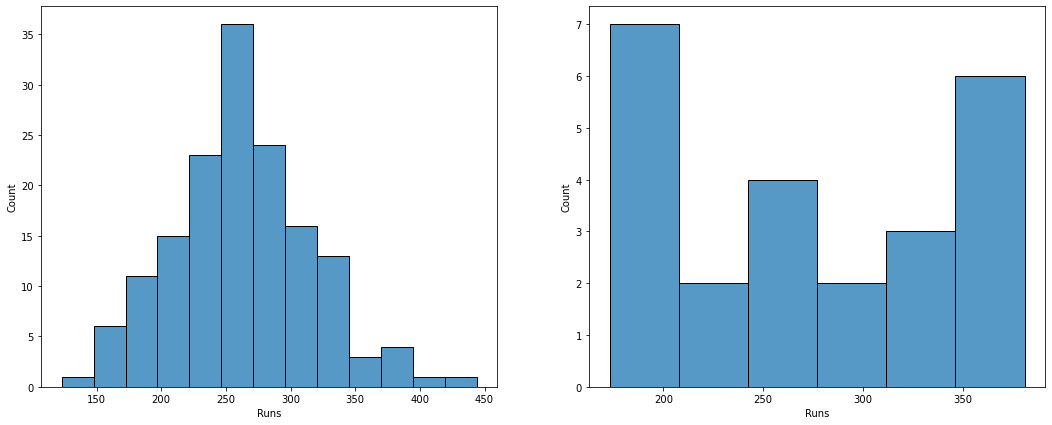

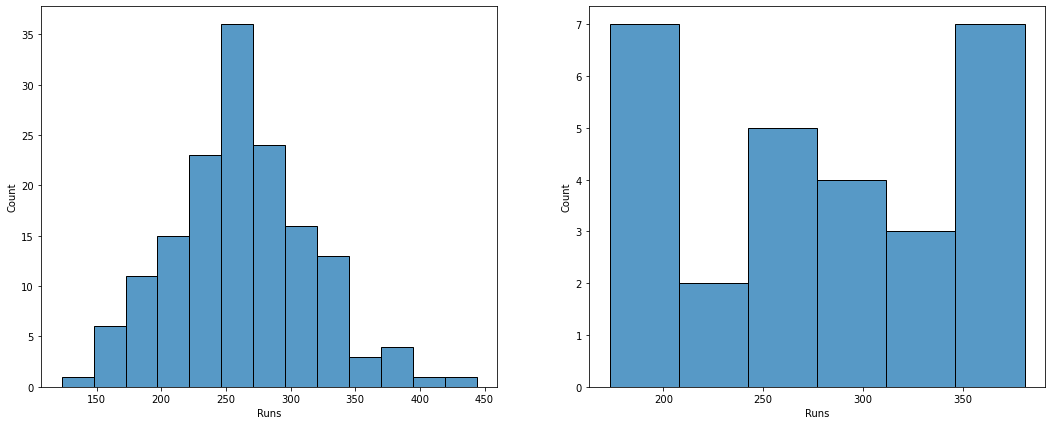

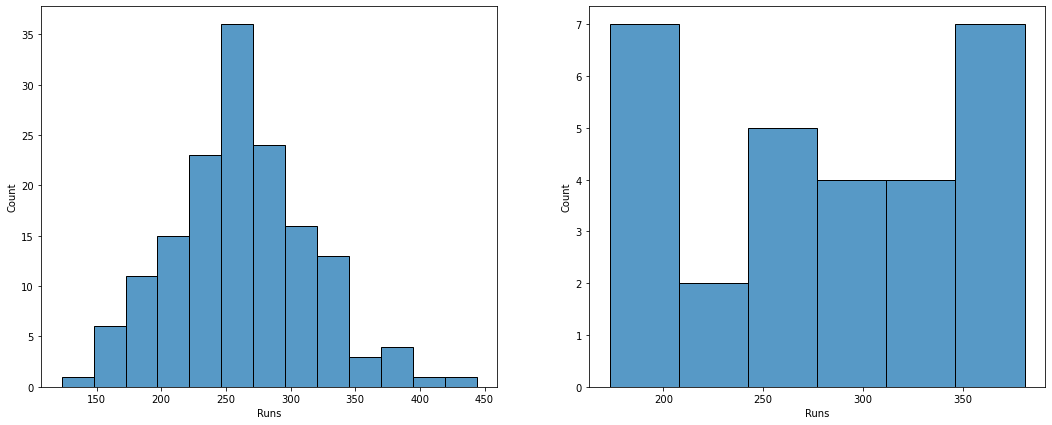

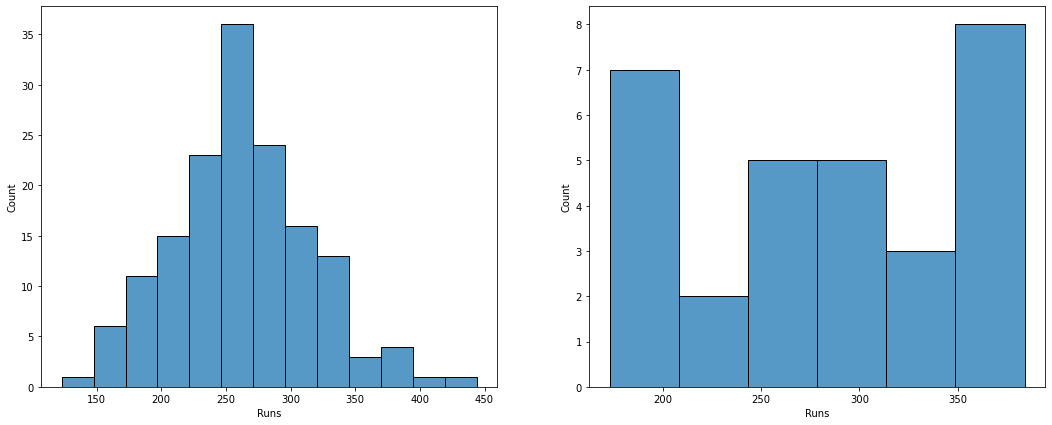

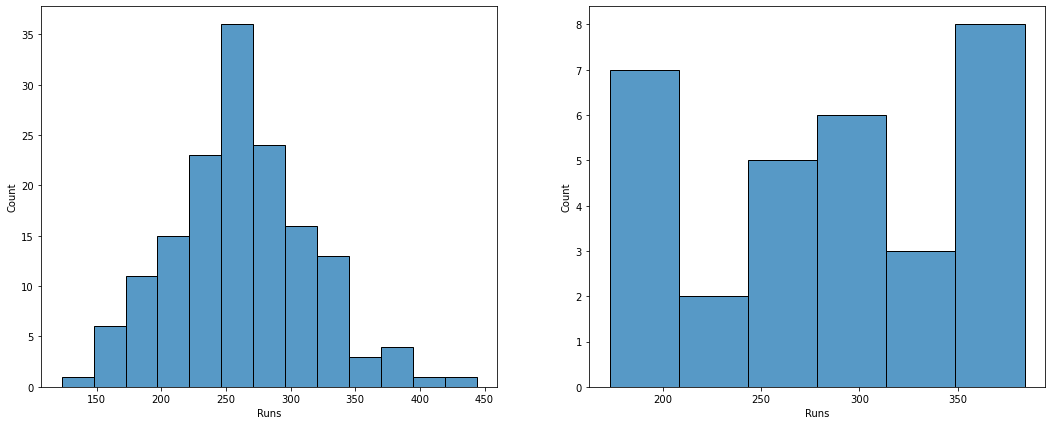

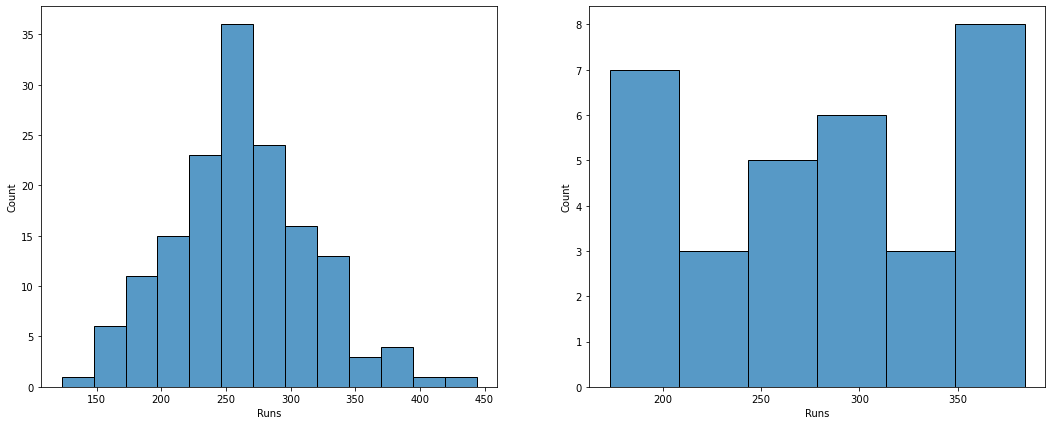

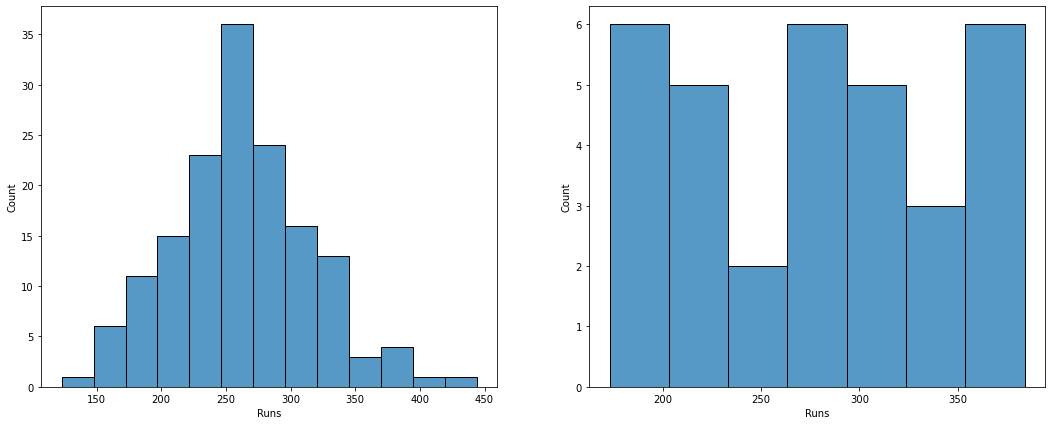

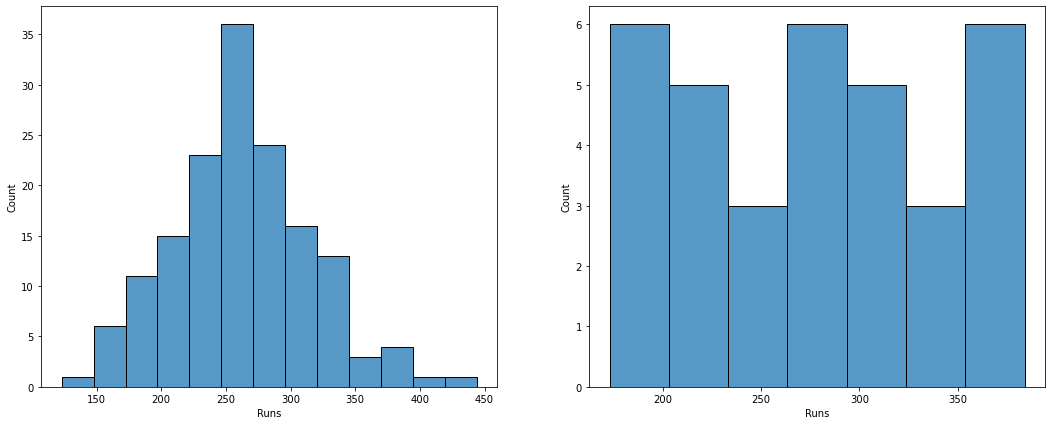

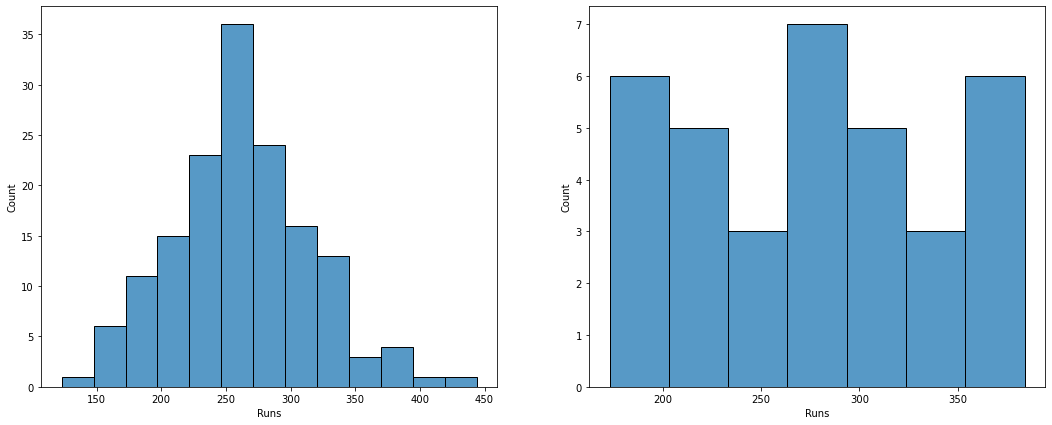

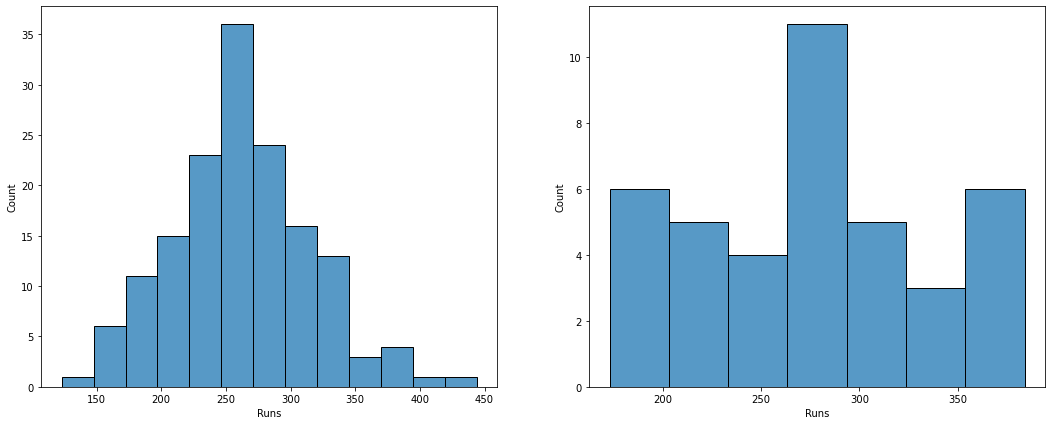

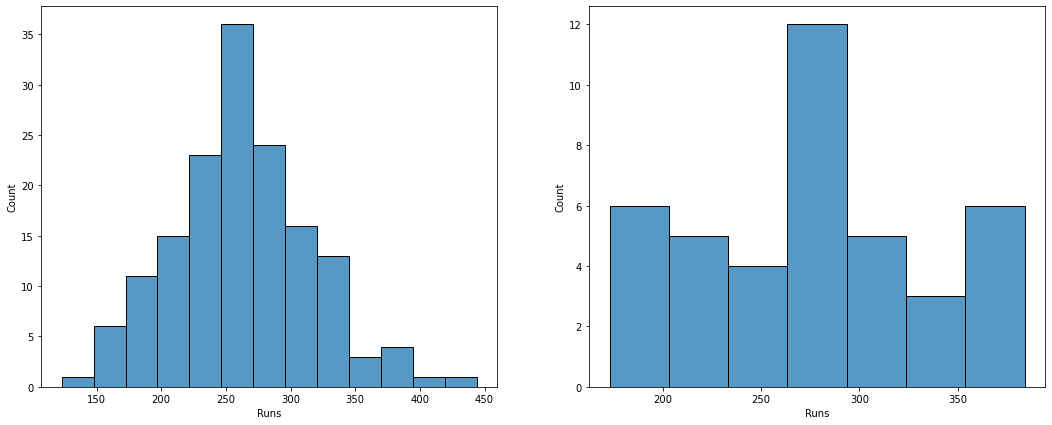

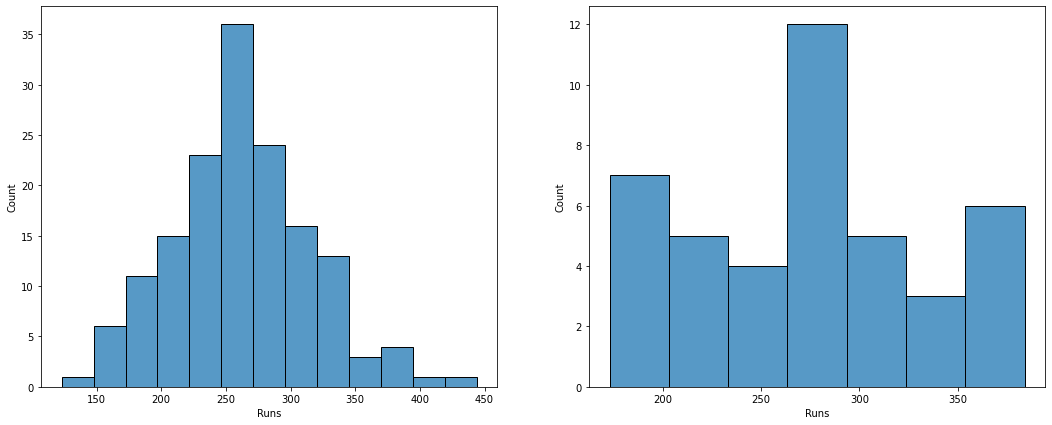

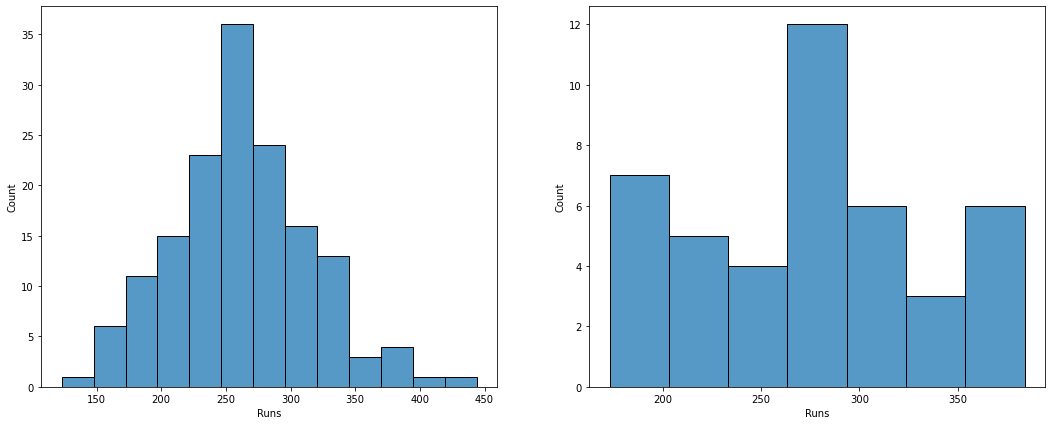

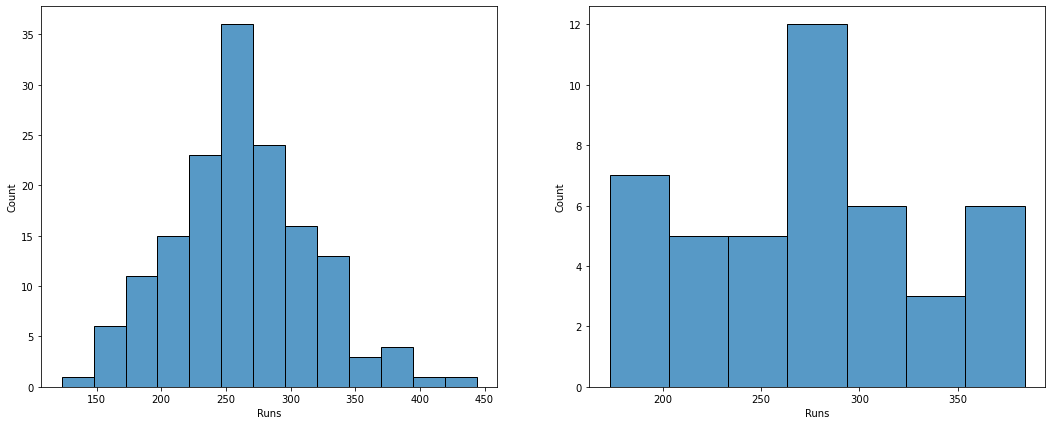

In [27]:
for i in np.arange(1, len(target)+1):
    stat = stats.ks_2samp(baseline["Runs"] , target[0:i]["Runs"] , mode="asymp")
    if stat.pvalue <= 0.3:
        print("Drift detected with pvalue:\t",stat.pvalue)
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 7))
        sns.histplot(x=baseline["Runs"], ax=ax1)
        sns.histplot(x=target[0:i]["Runs"], ax=ax2)
        #break

<AxesSubplot:xlabel='Runs', ylabel='Probability'>

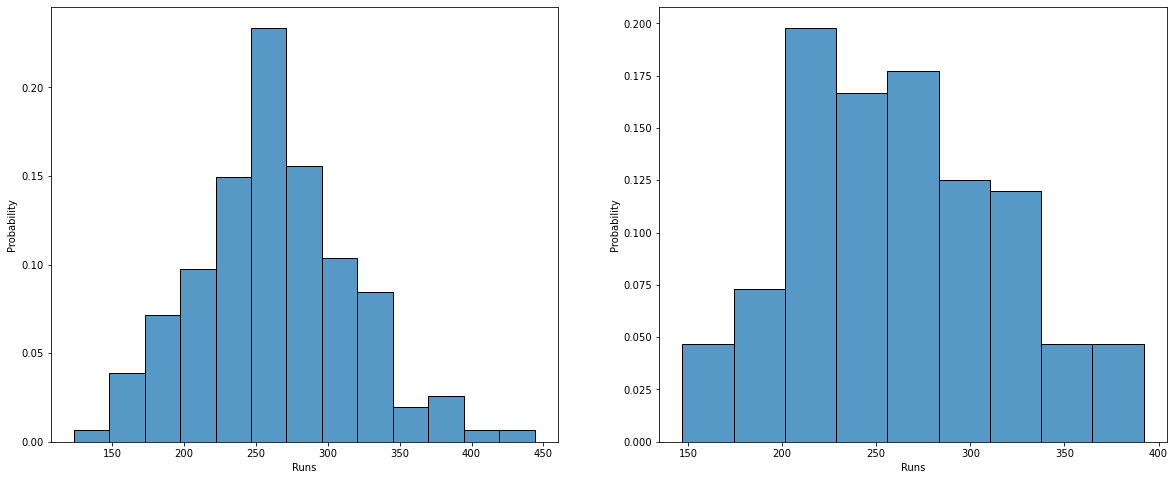

In [28]:
f, axes = plt.subplots(1, 2)
sns.histplot(x=baseline["Runs"], stat="probability", ax=axes[0])
sns.histplot(x=target["Runs"], stat="probability", ax=axes[1])

<AxesSubplot:xlabel='Runs', ylabel='Count'>

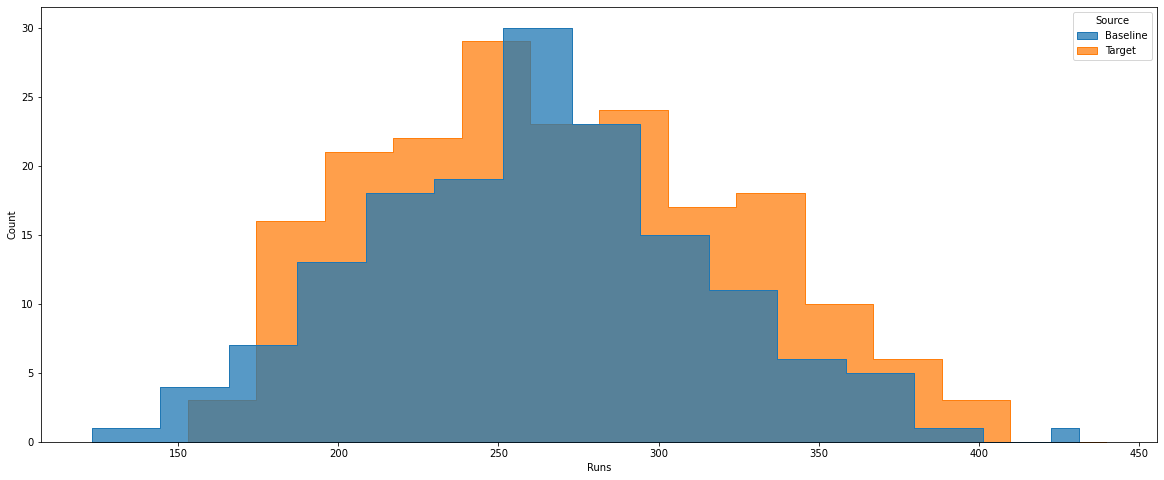

In [29]:
t1 = baseline[["Runs"]].copy()
t1["Source"] = "Baseline"

t2 = target[["Runs"]].copy()
t2["Source"] = "Target"

t = t1.append(t2)

sns.histplot(data=t, x="Runs", hue="Source", multiple="dodge", element="step", fill=True,
    cumulative=False, shrink=.8)

In [30]:
kswin = KSWIN(alpha=0.01, window_size=200, stat_size=154)

df = odi_sorted_df[(odi_sorted_df["Date"] >= "2016-01-01") & (odi_sorted_df["Date"] < "2018-01-01") & (odi_sorted_df["Balls"] >= 240) ]

for i in np.arange(0,len(df)):
    
    
    kswin.add_element(df.iloc[i,:]["Runs"])
    if kswin.detected_change():
        print("\rIteration {}".format(i))
        print(df.iloc[i,:])
        print("\r KSWINReject Null Hyptheses")
        #detections.append(i)

Iteration 204
Team                      Ireland
Runs                          262
Wkts                           10
Balls                         281
Ave                          26.2
RPO                          5.59
Result                       lost
Opposition          v Afghanistan
Ground              Greater Noida
Date          2017-03-15 00:00:00
Name: 7698, dtype: object
 KSWINReject Null Hyptheses
Iteration 250
Team                   Bangladesh
Runs                          182
Wkts                           10
Balls                         267
Ave                          18.2
RPO                          4.08
Result                        n/r
Opposition            v Australia
Ground                   The Oval
Date          2017-06-05 00:00:00
Name: 7756, dtype: object
 KSWINReject Null Hyptheses
Iteration 313
Team                   Bangladesh
Runs                          278
Wkts                            7
Balls                         300
Ave                         39.71


# Testing

In [31]:
a = [10,9,11,8,12,7,13,6,14,5]
b = [10,10,12,10,14,10,16,10,18,10]


In [32]:
np.mean(a)

9.5

In [33]:
confidence_interval(a)

(7.334149410386608, 11.665850589613392)

In [34]:
confidence_interval(b)

(9.867217773488166, 14.132782226511834)

In [35]:
a = ["121" , "!21", "232"]

In [36]:
[tuple(s.split() + ["source_table_name"]) for s in a]

[('121', 'source_table_name'),
 ('!21', 'source_table_name'),
 ('232', 'source_table_name')]

In [37]:
a.append("Dfs")
a.con

AttributeError: 'list' object has no attribute 'con'

In [ ]:
a